In [1]:
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn import metrics

## Regression

In [14]:
data = pd.read_csv("facebook_train.csv")
data.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share
0,124050,Photo,3,6,4,17,1,3,77,16
1,132556,Photo,2,8,3,24,0,11,313,50
2,92786,Photo,2,2,6,17,1,2,145,39
3,135632,Photo,1,9,2,1,0,2,299,49
4,139540,Link,1,12,3,17,1,7,229,21


In [15]:
mapper = DataFrameMapper([
     (['category'], sklearn.preprocessing.OneHotEncoder()),
     (['month'], sklearn.preprocessing.OneHotEncoder()),
     (['weekday'], sklearn.preprocessing.OneHotEncoder()),
     (['hour'], None),#sklearn.preprocessing.OneHotEncoder()),
     ("type", sklearn.preprocessing.LabelBinarizer()),
     (["total_followers"], sklearn.preprocessing.StandardScaler()),
     ("paid", None),
#      ("comment", None),
#      ("share", None)
], df_out=True)
processed_data = mapper.fit_transform(data.copy())

pred_target = "like"

# Select features
exclude = [pred_target, "comment", "share"]
features = list(set(list(processed_data)) - set(exclude))

In [16]:
x, x_test, y, y_test = train_test_split(data, data.like, test_size=0.2)
lr = linear_model.LinearRegression()

# Pipeline will process data, then select the k best features, 
# then fit a linear model using these features. This will be evaluated using
# cross validating with 8 folds.
pipe = sklearn.pipeline.Pipeline([
    ('process', mapper),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('lm', sklearn.linear_model.Lasso(alpha=0.02))])

for k in range(1, 15):
    pipe.set_params(select__k=k)
    cv_scores = np.round(cross_validate(pipe, X=x, y=y, cv=8)["test_score"], 2)
    print (k, np.average(cv_scores))

(1, -0.26625000000000004)
(2, -0.295)
(3, -0.2525)
(4, -0.265)
(5, -0.29625)
(6, -0.33875)
(7, -0.33999999999999997)
(8, -0.36)
(9, -0.3925)
(10, -0.3975)
(11, -0.41875)
(12, -0.43124999999999997)
(13, -0.42874999999999996)
(14, -0.42875)


In [17]:
pipe.set_params(select__k=5)
pipe.fit(x, y)

predictions = pipe.predict(x_test)
metrics_to_run = [metrics.mean_squared_error, metrics.mean_absolute_error, metrics.median_absolute_error, metrics.r2_score]
for metric in metrics_to_run: 
    print("{}: {}".format(metric.__name__, metric(predictions, y_test)))
    
selected_features = pipe.named_steps['select'].get_support()
for selected, feature in zip(selected_features, features):
    print selected, feature

pipe.named_steps['lm'].coef_

mean_squared_error: 106404.805671
mean_absolute_error: 184.995811873
median_absolute_error: 130.174005017
r2_score: -9.09081313051
True category_2
True category_1
True category_0
False type_Photo
False type_Status
False month_10
False month_11
False month_4
False month_5
True month_6
False month_7
False month_0
False month_1
False month_2
False month_3
False month_8
False month_9
False type_Video
False paid
False weekday_2
False weekday_3
False weekday_0
False weekday_1
False weekday_6
False weekday_4
False hour
False weekday_5
False type_Link
True total_followers


array([-110.76000638,   -0.        ,   25.44104421,  150.87244067,
        121.41190235])

In [ ]:
test_data = pd.read_csv("facebook_test_2.csv")

mapper = DataFrameMapper([
     (['category'], sklearn.preprocessing.OneHotEncoder()),
     (['month'], sklearn.preprocessing.OneHotEncoder()),
     (['weekday'], sklearn.preprocessing.OneHotEncoder()),
     (['hour'], None),#sklearn.preprocessing.OneHotEncoder()),
     ("type", sklearn.preprocessing.LabelBinarizer()),
     (["total_followers"], sklearn.preprocessing.StandardScaler()),
     ("paid", None)
], df_out=True)

processed_test_data = mapper.fit_transform(test_data.copy())
predicted = pipe.named_steps['lm'].predict(processed_test_data[["category_2", "category_0", "month_0", "month_11", "total_followers"]])
# processed_test_data.head()
metrics_to_run = [metrics.mean_squared_error, metrics.mean_absolute_error, metrics.median_absolute_error, metrics.r2_score]
for metric in metrics_to_run: 
    print(metric.__name__, metric(predicted, test_data["like"]))

## Classifier

In [18]:
cas_data = pd.read_csv("casualty_train.csv")
cas_data.head()

,casualty_class,gender,age,severe,pedestrian_location,pedestrian_movement,travel,year
0,passenger,female,33,False,NaN,NaN,motorbike,2007
1,passenger,female,20,False,NaN,NaN,car,2005
2,passenger,male,52,False,NaN,NaN,car,2006
3,passenger,female,17,False,NaN,NaN,pedestrian,2012
4,passenger,female,20,False,NaN,NaN,motorbike,2010


In [19]:
cas_data = cas_data.loc[cas_data.age != 'Unknown']
cas_data.loc[np.logical_not(cas_data.pedestrian_location == cas_data.pedestrian_location), 'pedestrian_location'] = ''
cas_data.loc[np.logical_not(cas_data.pedestrian_movement == cas_data.pedestrian_movement), 'pedestrian_movement'] = ''
cas_data.severe = cas_data.severe.astype('int')

cas_mapper = DataFrameMapper([
     (['casualty_class'], sklearn.preprocessing.LabelBinarizer()),
     (['gender'], sklearn.preprocessing.LabelBinarizer()),
     (['travel'], sklearn.preprocessing.LabelBinarizer()),
     ("age", None),
     ("year", None),
], df_out=True)
processed_cas_data = cas_mapper.fit_transform(cas_data.copy())

pred_target = "severe"

# Select features
exclude = [pred_target]
features = list(set(list(processed_cas_data)) - set(exclude))
processed_cas_data.head()

,casualty_class_driver,casualty_class_passenger,casualty_class_pedestrian,gender,travel_bicycle,travel_bus,travel_car,travel_motorbike,travel_other,travel_pedestrian,travel_taxi,age,year
0,0,1,0,0,0,0,0,1,0,0,0,33,2007
1,0,1,0,0,0,0,1,0,0,0,0,20,2005
2,0,1,0,1,0,0,1,0,0,0,0,52,2006
3,0,1,0,0,0,0,0,0,0,1,0,17,2012
4,0,1,0,0,0,0,0,1,0,0,0,20,2010


In [50]:
x, x_test, y, y_test = train_test_split(cas_data, cas_data.severe, test_size=0.1, random_state=3, stratify=list(cas_data.severe))

pipe = sklearn.pipeline.Pipeline([
    ('process', cas_mapper),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif)),
    ('svc', sklearn.svm.LinearSVC(class_weight="balanced"))])

for k in range(1, 5):
    pipe.set_params(select__k=k)
    cv_scores = np.round(cross_validate(pipe, X=x, y=y, cv=3)["test_score"], 2)
    print (k, np.average(cv_scores))

(1, 0.5866666666666667)
(2, 0.5866666666666667)
(3, 0.49)
(4, 0.49)


In [51]:
pipe.set_params(select__k=2)
pipe.fit(x, y)

predictions = pipe.predict(x_test)
metrics_to_run = [metrics.accuracy_score, metrics.precision_score, metrics.recall_score, metrics.roc_auc_score]
for metric in metrics_to_run: 
    print("{}: {}".format(metric.__name__, metric(predictions, list(y_test))))
    
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)

accuracy_score: 0.484788329255
precision_score: 0.775414717142
recall_score: 0.146366920915
roc_auc_score: 0.544506510642


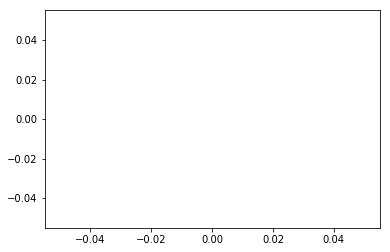

In [53]:
plt.plot(fpr, tpr)
plt.show()

In [55]:
tpr

array([nan, nan, nan])